<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 6: Finetuning for Text Classification

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.0
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.4.0
tensorflow version: 2.16.1
pandas version: 2.2.2


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/chapter-overview.webp" width=500px>

## 6.1 Different categories of finetuning

- No code in this section

- The most common ways to finetune language models are instruction-finetuning and classification finetuning
- Instruction-finetuning, depicted below, is the topic of the next chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/instructions.webp" width=500px>

- Classification finetuning, the topic of this chapter, is a procedure you may already be familiar with if you have a background in machine learning -- it's similar to training a convolutional network to classify handwritten digits, for example
- In classification finetuning, we have a specific number of class labels (for example, "spam" and "not spam") that the model can output
- A classification finetuned model can only predict classes it has seen during training (for example, "spam" or "not spam"), whereas an instruction-finetuned model can usually perform many tasks
- We can think of a classification-finetuned model as a very specialized model; in practice, it is much easier to create a specialized model than a generalist model that performs well on many different tasks

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/spam-non-spam.webp" width=500px>

## 6.2 Preparing the dataset

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-1.webp" width=500px>

- This section prepares the dataset we use for classification finetuning
- We use a dataset consisting of spam and non-spam text messages to finetune the LLM to classify them
- First, we download and unzip the dataset

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd

# 定义要下载的文件的URL地址，这里是一个包含短信垃圾短信数据集的压缩文件链接
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# 定义下载后保存的压缩文件的路径
zip_path = "sms_spam_collection.zip"
# 定义解压后文件保存的路径
extracted_path = "sms_spam_collection"
# 定义数据文件（解压后包含短信数据的TSV文件）的完整路径，通过Path对象拼接路径得到
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    此函数用于从指定的URL下载一个压缩文件，然后将其解压到指定的路径，并将解压后的文件重命名为带有.tsv扩展名的文件。

    参数:
    - url: 要下载的文件的URL地址。
    - zip_path: 下载后保存的压缩文件的路径。
    - extracted_path: 解压后文件保存的路径。
    - data_file_path: 数据文件（解压后包含短信数据的TSV文件）的完整路径。

    无返回值，但会在控制台打印相关的操作信息，如文件是否已存在、下载和解压完成后的保存路径等。
    """
    # 如果数据文件已经存在，就打印提示信息并直接返回，不再进行下载和解压操作
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # 下载文件的操作
    with urllib.request.urlopen(url) as response:
        # 以二进制写入模式打开要保存的文件
        with open(zip_path, "wb") as out_file:
            # 将从URL读取到的内容写入到本地文件中
            out_file.write(response.read())

    # 解压文件的操作
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # 将压缩文件中的所有内容解压到指定的路径下
        zip_ref.extractall(extracted_path)

    # 将解压后的文件重命名为带有.tsv扩展名的文件
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)

    print(f"File downloaded and saved as {data_file_path}")


# 调用download_and_unzip_spam_data函数，传入相关参数，执行下载、解压和重命名等操作
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

# 使用pandas库的read_csv函数读取刚刚处理好的TSV文件，将其转换为一个DataFrame对象
# sep="\t"表示文件是用制表符（\t）作为分隔符的
# header=None表示文件中没有表头，需要我们自己指定列名
# names=["Label", "Text"]指定了两列的列名，分别为"Label"（表示短信是否为垃圾短信的标签）和"Text"（表示短信的文本内容）
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# 最后将读取到的DataFrame对象打印出来，展示数据的基本情况，包括行数、列数以及具体的数据内容等
df

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


- The dataset is saved as a tab-separated text file, which we can load into a pandas DataFrame

In [3]:
import pandas as pd

# 使用pandas库的read_csv函数来读取之前处理好并确定路径的短信数据集文件（data_file_path所指向的文件）。
# read_csv函数是pandas中用于读取逗号分隔值（CSV）格式文件的常用函数，在这里也可以用来读取以制表符（\t）分隔的文件。

# 参数解释：
# - sep="\t"：指定文件的分隔符为制表符（\t），因为我们的数据集文件是用制表符来分隔每一行中的不同数据项的。
# - header=None：表示该文件没有自带的表头行，即文件第一行就是实际的数据内容，而不是列名信息。
# - names=["Label", "Text"]：由于文件没有表头，我们在这里手动指定了两列的列名，分别为"Label"和"Text"。"Label"列预计用于存储短信是否为垃圾短信的标签信息，"Text"列则用于存储短信的具体文本内容。

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

# 将读取到的数据存储在名为df的DataFrame对象中。DataFrame是pandas库中用于处理二维表格数据的核心数据结构，它类似于电子表格或数据库表，具有行和列，可以方便地进行各种数据操作和分析。

# 最后再次输出df，这一步主要是为了在控制台展示读取到的数据内容，以便直观地查看数据集的基本情况，比如查看数据的行数、列数，以及具体的短信文本内容和对应的标签等信息。
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- When we check the class distribution, we see that the data contains "ham" (i.e., "not spam") much more frequently than "spam"

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- For simplicity, and because we prefer a small dataset for educational purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class
- (Next to undersampling, there are several other ways to deal with class balances, but they are out of the scope of a book on LLMs; you can find examples and more information in the [`imbalanced-learn` user guide](https://imbalanced-learn.org/stable/user_guide.html))

In [5]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- Next, we change the string class labels "ham" and "spam" into integer class labels 0 and 1:

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

- Let's now define a function that randomly divides the dataset into training, validation, and test subsets

In [7]:
def random_split(df, train_frac, validation_frac):
    """
    此函数用于将输入的DataFrame按照指定的比例随机划分为训练集、验证集和测试集。

    参数:
    - df: 要进行划分的原始DataFrame对象，包含了待划分的数据。
    - train_frac: 训练集所占的比例，是一个介于0到1之间的小数，表示训练集在整个数据集中所占的份额。
    - validation_frac: 验证集所占的比例，同样是一个介于0到1之间的小数，表示验证集在整个数据集中所占的份额。

    返回值:
    - train_df, validation_df, test_df: 分别返回划分好的训练集、验证集和测试集对应的DataFrame对象。
    """

    # 对整个DataFrame进行随机打乱操作
    # sample(frac=1)表示按照100%的比例对DataFrame进行随机抽样，实际上就是打乱了DataFrame中数据的顺序
    # random_state=123用于设置随机种子，这样可以保证每次运行此函数时，只要随机种子不变，得到的打乱结果是相同的，便于重现实验结果
    # reset_index(drop=True)用于重置索引，将打乱后的DataFrame的索引重新设置为从0开始的连续整数，并且丢弃原来的索引
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 计算划分训练集、验证集和测试集的索引位置

    # 计算训练集结束的索引位置，通过将DataFrame的总长度乘以训练集所占的比例，然后取整得到
    train_end = int(len(df) * train_frac)

    # 计算验证集结束的索引位置，先计算出训练集的结束索引，再加上通过将DataFrame的总长度乘以验证集所占的比例并取整得到的值
    validation_end = train_end + int(len(df) * validation_frac)

    # 根据计算出的索引位置对DataFrame进行划分

    # 选取从开始到训练集结束索引位置的数据作为训练集，切片操作df[:train_end]实现了这一点
    train_df = df[:train_end]

    # 选取从训练集结束索引位置到验证集结束索引位置的数据作为验证集，切片操作df[train_end:validation_end]实现了这一点
    validation_df = df[train_end:validation_end]

    # 选取从验证集结束索引位置到DataFrame末尾的数据作为测试集，切片操作df[validation_end:]实现了这一点
    test_df = df[validation_end:]

    return train_df, validation_df, test_df


# 调用random_split函数，将balanced_df按照训练集占0.7、验证集占0.1的比例进行划分
# 这里隐含的测试集比例为0.2，因为整个数据集按照比例划分后，剩下的部分就是测试集所占的份额
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

# 将划分好的训练集保存为名为"train.csv"的文件，设置index=None表示不保存索引列，只保存数据内容
train_df.to_csv("train.csv", index=None)

# 将划分好的验证集保存为名为"validation.csv"的文件，同样设置index=None不保存索引列
validation_df.to_csv("validation.csv", index=None)

# 将划分好的测试集保存为名为"test.csv"的文件，也设置index=None不保存索引列
test_df.to_csv("test.csv", index=None)

## 6.3 Creating data loaders

- Note that the text messages have different lengths; if we want to combine multiple training examples in a batch, we have to either
  1. truncate all messages to the length of the shortest message in the dataset or batch
  2. pad all messages to the length of the longest message in the dataset or batch

- We choose option 2 and pad all messages to the longest message in the dataset
- For that, we use `<|endoftext|>` as a padding token, as discussed in chapter 2

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/pad-input-sequences.webp?123" width=500px>

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- The `SpamDataset` class below identifies the longest sequence in the training dataset and adds the padding token to the others to match that sequence length

In [9]:
import torch
from torch.utils.data import Dataset
import pandas as pd


class SpamDataset(Dataset):
    """
    SpamDataset类是一个自定义的数据集类，用于处理短信垃圾短信分类任务中的数据。
    它继承自PyTorch的Dataset类，以便能够与PyTorch的数据加载器（DataLoader）等工具配合使用。

    该数据集类的主要功能是读取包含短信文本和标签的CSV文件，对短信文本进行分词编码、截断和填充等预处理操作，
    然后能够根据索引提供单个数据样本（包括编码后的短信文本和对应的标签），并返回数据集的大小。
    """

    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        """
        类的初始化方法，用于设置数据集的相关属性和进行数据预处理。

        参数:
        - csv_file: 包含短信数据的CSV文件的路径，该文件应包含两列，一列是短信的文本内容（"Text"列），另一列是短信是否为垃圾短信的标签（"Label"列）。
        - tokenizer: 分词器对象，用于对短信文本进行分词和编码操作，将文本转换为模型可处理的编码形式。
        - max_length: 可选参数，用于指定短信编码序列的最大长度。如果未指定（即None），则会自动计算数据集中最长的编码序列长度作为最大长度。
        - pad_token_id: 填充标记的ID，用于在短信编码序列长度不足最大长度时进行填充，使其达到最大长度，默认值为50256。
        """
        # 读取CSV文件并将数据存储在self.data属性中，self.data是一个DataFrame对象，包含了短信文本和标签信息
        self.data = pd.read_csv(csv_file)

        # 对数据集中的每条短信文本进行分词和编码操作
        # 使用tokenizer的encode方法对每条短信的文本内容进行处理，将其转换为编码形式，
        # 并将所有编码后的短信文本存储在self.encoded_texts列表中
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            # 如果未指定最大长度，调用_longest_encoded_length方法来计算数据集中最长的编码序列长度，
            # 并将其设置为self.max_length属性的值，即自动确定最大长度
            self.max_length = self._longest_encoded_length()
        else:
            # 如果指定了最大长度，将其赋值给self.max_length属性
            self.max_length = max_length
            # 对于长度超过最大长度的编码序列，进行截断操作，只保留前max_length个编码元素
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
                ]

        # 对编码后的短信文本进行填充操作，使所有短信编码序列的长度都达到self.max_length
        # 通过在编码序列末尾添加填充标记（pad_token_id）来实现填充，添加的填充标记数量为self.max_length减去编码序列的原始长度
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
            ]

    def __getitem__(self, index):
        """
        根据给定的索引获取数据集中的单个数据样本。

        参数:
        - index: 要获取的数据样本的索引。

        返回值:
        - 返回一个包含编码后的短信文本和对应的标签的元组。
        编码后的短信文本是一个torch.tensor类型的张量，数据类型为torch.long；对应的标签也是一个torch.tensor类型的张量，数据类型为torch.long。
        """
        # 根据索引获取编码后的短信文本
        encoded = self.encoded_texts[index]
        # 根据索引从self.data中获取对应的短信标签
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        """
        返回数据集的大小，即数据集中包含的数据样本数量。

        返回值:
        - 返回一个整数，表示数据集的大小，其值等于self.data中包含的行数，也就是短信数据的数量。
        """
        return len(self.data)

    def _longest_encoded_length(self):
        """
        计算数据集中最长的编码序列长度的私有方法。

        返回值:
        - 返回一个整数，表示数据集中最长的编码序列长度。
        """
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [10]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- We also pad the validation and test set to the longest training sequence
- Note that validation and test set samples that are longer than the longest training example are being truncated via `encoded_text[:self.max_length]` in the `SpamDataset` code
- This behavior is entirely optional, and it would also work well if we set `max_length=None` in both the validation and test set cases

In [11]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

- Next, we use the dataset to instantiate the data loaders, which is similar to creating the data loaders in previous chapters

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/batch.webp" width=500px>

In [12]:
from torch.utils.data import DataLoader

# 设置用于数据加载的工作进程数量为0，即不使用多进程来加载数据，数据加载将在主线程中进行。
# 当num_workers为0时，数据加载相对简单直接，但在处理大规模数据时可能会比较慢。
# 如果设置为大于0的值，例如num_workers = 4，就会启用4个工作进程来并行加载数据，可加快数据加载速度，但可能会占用更多系统资源。
num_workers = 0
# 设置每个批次的数据样本数量为8，即每次从数据集中取出8个数据样本组成一个批次，用于后续的模型训练、评估等操作。
batch_size = 8

# 设置随机种子为123，这一步很重要，因为在后续涉及到数据加载过程中的随机操作（如shuffle=True时的数据集打乱操作）时，
# 设置相同的随机种子可以保证每次运行程序都能得到相同的随机结果，便于调试和重现实验结果。
torch.manual_seed(123)

# 使用DataLoader类创建训练数据加载器train_loader，用于按批次加载训练数据集train_dataset。
train_loader = DataLoader(
    # 指定要加载的数据集为之前已经准备好的训练数据集train_dataset。
    dataset=train_dataset,
    # 设置每个批次的大小为batch_size，即每次加载8个数据样本作为一个批次。
    batch_size=batch_size,
    # 设置为True，表示在每个 epoch（训练轮次）开始前，会对训练数据集进行随机打乱操作，这样可以使模型在不同轮次训练中以不同顺序接触到数据，有助于提高模型的泛化能力。
    shuffle=True,
    # 设置用于数据加载的工作进程数量为num_workers，这里是0，即不使用多进程加载数据。
    num_workers=num_workers,
    # 设置为True，表示如果最后一个批次的样本数量不足batch_size，就丢弃这个批次。
    # 这样做的好处是可以保证每个批次的大小都是固定的batch_size，方便后续的模型训练操作，例如在计算损失函数等时，批次大小固定会更便于处理。
    drop_last=True,
)

# 使用DataLoader类创建验证数据加载器val_loader，用于按批次加载验证数据集val_dataset。
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

# 使用DataLoader类创建测试数据加载器test_loader，用于按批次加载测试数据集test_dataset。
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- As a verification step, we iterate through the data loaders and ensure that the batches contain 8 training examples each, where each training example consists of 120 tokens

In [13]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- Lastly, let's print the total number of batches in each dataset

In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 Initializing a model with pretrained weights

- In this section, we initialize the pretrained model we worked with in the previous chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-2.webp" width=500px>

In [15]:
# 选择要使用的模型名称，这里选择了"gpt2-small (124M)"，后续会根据这个选择来配置相应的模型参数。
CHOOSE_MODEL = "gpt2-small (124M)"
# 定义输入提示文本，该文本将作为模型生成后续内容的起始输入，这里是"Every effort moves"。
INPUT_PROMPT = "Every effort moves"

# 定义基础配置字典，包含了一些模型的通用配置参数。
BASE_CONFIG = {
    # 词汇表大小，这里设置为50257，表示模型所能处理的词汇数量。
    "vocab_size": 50257,
    # 上下文长度，即模型在处理文本时能够考虑的前后文的最大长度，这里设置为1024。
    "context_length": 1024,
    # 丢弃率，用于在模型训练过程中的Dropout操作，这里设置为0.0，表示不进行丢弃操作（即关闭Dropout）。
    "drop_rate": 0.0,
    # 查询 - 键 - 值（Query - Key - Value）是否有偏置，这里设置为True，表示启用QKV偏置。
    "qkv_bias": True
}

# 定义一个字典，存储不同规模的GPT2模型的特定配置参数，每个键是模型名称，对应的值是一个包含该模型特定参数的字典。
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 将根据选择的模型名称（CHOOSE_MODEL）对应的特定配置参数更新到基础配置字典BASE_CONFIG中。
# 这样，BASE_CONFIG就包含了所选模型的完整配置信息，包括通用配置和特定配置。
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# 进行断言检查，确保训练数据集的最大长度不超过模型的上下文长度。
# 如果训练数据集的最大长度超过了模型的上下文长度，就会抛出异常，并给出相应的提示信息，告知用户需要重新初始化数据集，设置合适的最大长度。
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [16]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|███████████████████████████| 77.0/77.0 [00:00<00:00, 24.2kiB/s]
encoder.json: 100%|███████████████████████| 1.04M/1.04M [00:00<00:00, 2.53MiB/s]
hparams.json: 100%|█████████████████████████| 90.0/90.0 [00:00<00:00, 37.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████| 498M/498M [00:24<00:00, 20.7MiB/s]
model.ckpt.index: 100%|████████████████████| 5.21k/5.21k [00:00<00:00, 924kiB/s]
model.ckpt.meta: 100%|██████████████████████| 471k/471k [00:00<00:00, 1.89MiB/s]
vocab.bpe: 100%|████████████████████████████| 456k/456k [00:00<00:00, 1.79MiB/s]


- To ensure that the model was loaded correctly, let's double-check that it generates coherent text

In [17]:
# 从之前定义的模块previous_chapters中导入以下三个函数：
# - generate_text_simple：用于根据给定的模型、输入索引序列以及相关参数生成新的文本标记（token）序列，并返回生成后的索引序列。
# - text_to_token_ids：用于将输入的文本通过指定的分词器（tokenizer）转换为对应的标记（token）索引序列。
# - token_ids_to_text：用于将标记索引序列通过指定的分词器转换回文本形式。
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)
# 定义一个起始文本，该文本将作为输入提供给模型，用于生成后续的文本内容，这里定义为"Every effort moves you"。
text_1 = "Every effort moves you"
# 调用generate_text_simple函数来生成新的文本标记序列。
# 传入以下参数：
# - model：已配置好的模型对象，该模型将基于输入的起始文本生成后续的文本标记。
# - idx：通过text_to_token_ids函数将起始文本text_1转换为标记索引序列，并作为生成新标记的起始输入序列提供给模型。
# - max_new_tokens：指定要生成的新标记的最大数量为15，即生成的后续文本大致由这15个新标记组成（具体长度可能会因遇到结束标记等情况提前结束生成）。
# - context_size：从之前定义的BASE_CONFIG配置字典中获取上下文长度的值，用于在生成新标记时确定考虑的先前标记的数量，这与模型的输入要求和生成逻辑相关。
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
# 将生成的标记索引序列通过token_ids_to_text函数转换回文本形式，并打印输出结果，以便查看基于起始文本和模型生成的具体文本内容。
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- Before we finetune the model as a classifier, let's see if the model can perhaps already classify spam messages via prompting

In [18]:
# 定义一个新的文本内容，该文本通常是一个询问某段特定文本是否为垃圾短信（'spam'）的表述，
# 并要求以'yes'或'no'来回答。这里具体的文本内容是询问一段类似中奖通知的文本是否为垃圾短信。
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

# 调用generate_text_simple函数来生成基于text_2的新的文本标记（token）序列。

# 传入以下参数：
# - model：已配置好的模型对象，该模型将基于输入的text_2文本生成后续的文本标记。
# - idx：通过text_to_token_ids函数将text_2文本转换为标记索引序列，并作为生成新标记的起始输入序列提供给模型。
# - max_new_tokens：指定要生成的新标记的最大数量为23，即生成的后续文本大致由这23个新标记组成（具体长度可能会因遇到结束标记等情况提前结束生成）。
# - context_size：从之前定义的BASE_CONFIG配置字典中获取上下文长度的值，用于在生成新标记时确定考虑的先前标记的数量，这与模型的输入要求和生成逻辑相关。
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

# 将生成的标记索引序列通过token_ids_to_text函数转换回文本形式，并打印输出结果，以便查看基于text_2文本和模型生成的具体文本内容，
# 也就是模型对于所询问的那段文本是否为垃圾短信的回答情况。
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- As we can see, the model is not very good at following instructions
- This is expected, since it has only been pretrained and not instruction-finetuned (instruction finetuning will be covered in the next chapter)

## 6.5 Adding a classification head

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/lm-head.webp" width=500px>

- In this section, we are modifying the pretrained LLM to make it ready for classification finetuning
- Let's take a look at the model architecture first

In [19]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- Above, we can see the architecture we implemented in chapter 4 neatly laid out
- The goal is to replace and finetune the output layer
- To achieve this, we first freeze the model, meaning that we make all layers non-trainable

In [20]:
for param in model.parameters():
    param.requires_grad = False

- Then, we replace the output layer (`model.out_head`), which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary)
- Since we finetune the model for binary classification (predicting 2 classes, "spam" and "not spam"), we can replace the output layer as shown below, which will be trainable by default
- Note that we use `BASE_CONFIG["emb_dim"]` (which is equal to 768 in the `"gpt2-small (124M)"` model) to keep the code below more general

In [21]:
torch.manual_seed(123)
# 定义分类任务的类别数量，这里设置为2，通常表示一个二分类任务，比如在判断短信是否为垃圾短信的场景中，就只有两种类别：是垃圾短信（'spam'）和不是垃圾短信（'ham'）。
num_classes = 2
# 使用torch.nn.Linear创建一个新的线性层，作为模型的输出头。
# - in_features参数设置为BASE_CONFIG["emb_dim"]，表示输入特征的维度，这里是从之前定义的BASE_CONFIG配置字典中获取嵌入维度（emb_dim）的值，
#   该嵌入维度通常是模型在对输入文本进行处理后得到的特征向量的维度。
# - out_features参数设置为num_classes，即2，表示输出的特征维度，也就是模型最终输出的结果应该对应到的类别数量，这里是为了适应二分类任务。
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- Technically, it's sufficient to only train the output layer
- However, as I found in [Finetuning Large Language Models](https://magazine.sebastianraschka.com/p/finetuning-large-language-models), experiments show that finetuning additional layers can noticeably improve the performance
- So, we are also making the last transformer block and the final `LayerNorm` module connecting the last transformer block to the output layer trainable

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/trainable.webp" width=500px>

In [22]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

- We can still use this model similar to before in previous chapters
- For example, let's feed it some text input

In [23]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- What's different compared to previous chapters is that it now has two output dimensions instead of 50,257

In [24]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


- As discussed in previous chapters, for each input token, there's one output vector
- Since we fed the model a text sample with 4 input tokens, the output consists of 4 2-dimensional output vectors above

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/input-and-output.webp" width=500px>

- In chapter 3, we discussed the attention mechanism, which connects each input token to each other input token
- In chapter 3, we then also introduced the causal attention mask that is used in GPT-like models; this causal mask lets a current token only attend to the current and previous token positions
- Based on this causal attention mechanism, the 4th (last) token contains the most information among all tokens because it's the only token that includes information about all other tokens
- Hence, we are particularly interested in this last token, which we will finetune for the spam classification task

In [25]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/attention-mask.webp" width=200px>

## 6.6 Calculating the classification loss and accuracy

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-3.webp?1" width=500px>

- Before explaining the loss calculation, let's have a brief look at how the model outputs are turned into class labels

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/class-argmax.webp" width=600px>

In [26]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


- Similar to chapter 5, we convert the outputs (logits) into probability scores via the `softmax` function and then obtain the index position of the largest probability value via the `argmax` function

In [27]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


- Note that the softmax function is optional here, as explained in chapter 5, because the largest outputs correspond to the largest probability scores

In [28]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


- We can apply this concept to calculate the so-called classification accuracy, which computes the percentage of correct predictions in a given dataset
- To calculate the classification accuracy, we can apply the preceding `argmax`-based prediction code to all examples in a dataset and calculate the fraction of correct predictions as follows:

In [29]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    该函数用于计算在给定的数据加载器（data_loader）提供的数据上，模型（model）预测的准确率。
    参数:
    - data_loader: 一个PyTorch的数据加载器对象，用于按批次加载数据，每个批次包含输入数据和对应的目标数据。
    - model: 已经训练好或者待评估的模型对象，用于对输入数据进行预测。
    - device: 表示模型和数据将在其上进行操作的设备，如 'cuda'（GPU）或 'cpu'。
    - num_batches: 可选参数，用于指定要评估的批次数量。如果为None，则会评估数据加载器中的所有批次；如果指定了具体值，则会评估指定数量的批次，且该值不能超过数据加载器中的总批次数量。
    返回值:
    - 返回一个浮点数，表示模型在指定数据上预测的准确率，即正确预测的样本数量除以总样本数量。
    """

    # 将模型设置为评估模式，在这种模式下，模型的一些层（如Dropout层等）会按照评估时的行为进行设置，
    # 通常是禁用一些在训练时用于防止过拟合的随机操作，以得到更稳定的输出结果。
    model.eval()

    # 初始化正确预测的样本数量和总样本数量为0
    correct_predictions, num_examples = 0, 0

    # 如果没有指定num_batches，就将其设置为数据加载器中的总批次数量，即评估所有批次的数据
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果指定了num_batches，确保它不超过数据加载器中的总批次数量
        num_batches = min(num_batches, len(data_loader))

    # 遍历数据加载器中的批次数据
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # 如果当前批次索引小于要评估的批次数量num_batches
        if i < num_batches:
            # 将输入批次和目标批次的数据都移动到指定的设备（如GPU或CPU）上，以便在该设备上进行后续的模型预测操作
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # 在不计算梯度的情况下进行模型预测，因为在评估准确率时不需要计算梯度来更新模型参数
            with torch.no_grad():
                # 使用模型对输入批次进行预测，得到预测结果的对数几率（logits）张量。
                # 这里取最后一个输出标记的对数几率（logits），即[:, -1, :]，具体含义可能取决于模型的结构和任务要求，
                # 例如在文本生成相关任务中，可能是关注最后生成的那个标记的预测情况。
                logits = model(input_batch)[:, -1, :]

            # 通过torch.argmax函数找到预测结果对数几率张量中每个样本在最后一个维度（dim=-1）上的最大值索引，
            # 这些索引将作为预测的标签，对应着不同的类别。
            predicted_labels = torch.argmax(logits, dim=-1)

            # 更新总样本数量，将当前批次中预测标签的数量（即预测结果的张量形状在第0维度上的值）累加到总样本数量上
            num_examples += predicted_labels.shape[0]

            # 计算当前批次中正确预测的样本数量，通过比较预测标签和目标批次中的真实标签，
            # 将相等的情况进行求和（.sum()）并转换为普通的数值（.item()），然后累加到正确预测的样本数量上
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            # 如果当前批次索引大于等于要评估的批次数量num_batches，就跳出循环，不再继续评估后续批次的数据
            break

    # 返回模型在指定数据上预测的准确率，即正确预测的样本数量除以总样本数量
    return correct_predictions / num_examples

- Let's apply the function to calculate the classification accuracies for the different datasets:

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 以下是一段关于在Apple Silicon芯片上运行代码的注释说明：
# 注意：
# 如果适用的话，取消注释下面这些行将允许代码在Apple Silicon芯片上运行，
# 在Apple Silicon芯片上运行速度大约是在Apple CPU上运行速度的2倍（以M3 MacBook Air为例进行测量）。
# 在编写这段代码时（指当前代码所在的这个项目或文档的编写时间），在PyTorch 2.4版本中，通过CPU和苹果的MPS（Metal Performance Shaders，苹果用于加速机器学习计算的技术）得到的结果是相同的。
# 然而，在PyTorch的早期版本中，当使用MPS时可能会观察到不同的结果。
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
# print(f"Running on {device} device.")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- As we can see, the prediction accuracies are not very good, since we haven't finetuned the model, yet

- Before we can start finetuning (/training), we first have to define the loss function we want to optimize during training
- The goal is to maximize the spam classification accuracy of the model; however, classification accuracy is not a differentiable function
- Hence, instead, we minimize the cross-entropy loss as a proxy for maximizing the classification accuracy (you can learn more about this topic in lecture 8 of my freely available [Introduction to Deep Learning](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression) class)

- The `calc_loss_batch` function is the same here as in chapter 5, except that we are only interested in optimizing the last token `model(input_batch)[:, -1, :]` instead of all tokens `model(input_batch)`

In [31]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

The `calc_loss_loader` is exactly the same as in chapter 5

In [32]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- Using the `calc_closs_loader`, we compute the initial training, validation, and test set losses before we start training

In [33]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


- In the next section, we train the model to improve the loss values and consequently the classification accuracy

## 6.7 Finetuning the model on supervised data

- In this section, we define and use the training function to improve the classification accuracy of the model
- The `train_classifier_simple` function below is practically the same as the `train_model_simple` function we used for pretraining the model in chapter 5
- The only two differences are that we now 
  1. track the number of training examples seen (`examples_seen`) instead of the number of tokens seen
  2. calculate the accuracy after each epoch instead of printing a sample text after each epoch

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/training-loop.webp?1" width=500px>

In [34]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    """
    该函数用于对分类模型进行简单的训练过程，包括在每个训练轮次（epoch）中对训练数据进行前向传播、计算损失、反向传播更新模型权重，
    并且在指定的评估频率下对模型在训练集和验证集上的性能进行评估，记录训练过程中的损失值和准确率等信息。

    参数:
    - model: 要进行训练的分类模型对象，应该是继承自PyTorch的nn.Module类的模型，已经进行了必要的初始化设置，例如设置了输入输出维度等。
    - train_loader: 用于加载训练数据的PyTorch数据加载器对象，按照设定的批次大小等参数将训练数据分批次提供给模型进行训练。
    - val_loader: 用于加载验证数据的PyTorch数据加载器对象，用于在训练过程中定期评估模型在未见过的验证数据上的性能，以便监控模型是否过拟合等情况。
    - optimizer: 优化器对象，例如常见的Adam、SGD等优化器，用于根据计算得到的损失梯度来更新模型的权重参数，以使得模型能够朝着损失减小的方向进行优化。
    - device: 表示模型和数据将在其上进行操作的设备，如 'cuda'（GPU）或 'cpu'，确保模型和数据都被移动到该设备上进行高效的计算。
    - num_epochs: 训练的轮次数，即整个训练数据集将被重复使用多少次进行模型训练。
    - eval_freq: 评估频率，表示每隔多少个训练步骤（step）就对模型在训练集和验证集上的性能进行一次评估。
    - eval_iter: 在每次评估时，用于指定从数据加载器中选取多少个批次的数据来进行评估，例如可以设置为从训练集和验证集中各选取固定数量的批次进行评估。

    返回值:
    - train_losses: 一个列表，记录了在每个评估点上模型在训练集上的损失值。
    - val_losses: 一个列表，记录了在每个评估点上模型在验证集上的损失值。
    - train_accs: 一个列表，记录了在每个训练轮次结束后模型在训练集上的准确率。
    - val_accs: 一个列表，记录了在每个训练轮次结束后模型在验证集上的准确率。
    - examples_seen: 一个整数，表示在整个训练过程中已经处理过的训练数据样本的总数（按照批次中的样本数量累加得到）。
    """
    # Initialize lists to track losses and examples seen
    # 初始化四个空列表，用于分别跟踪训练集上的损失值、验证集上的损失值、训练集上的准确率和验证集上的准确率。
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    # 初始化两个变量，用于跟踪已经处理过的训练数据样本数量和全局训练步骤数量。
    # 初始时，examples_seen设置为0，表示还没有处理过任何训练数据样本；global_step设置为 -1，作为训练步骤的计数起点。
    examples_seen, global_step = 0, -1
    # Main training loop
    # 主训练循环，将按照指定的训练轮次数（num_epochs）对整个训练数据集进行多次遍历训练。
    for epoch in range(num_epochs):
        # 将模型设置为训练模式，在这种模式下，模型的一些层（如Dropout层等）会按照训练时的行为进行设置，
        # 启用梯度计算等相关训练机制，以便进行后续的模型训练操作。
        model.train()
        for input_batch, target_batch in train_loader:
            # 在每个训练批次开始前，先使用优化器的zero_grad方法将上一个批次迭代计算得到的损失梯度清零。
            # 这是因为在PyTorch中，梯度是累加的，如果不清零，上一个批次的梯度会影响到当前批次的梯度计算，导致结果错误。
            optimizer.zero_grad()
            # 使用calc_loss_batch函数计算当前批次输入数据（input_batch）和目标数据（target_batch）在模型（model）上的损失值。
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 调用损失值的backward方法，根据计算得到的损失值计算模型中各个可训练参数的梯度，
            # 这些梯度将用于后续优化器更新模型权重参数。
            loss.backward()
            # 使用优化器的step方法，根据刚刚计算得到的损失梯度来更新模型的权重参数，
            # 使得模型能够朝着损失减小的方向进行优化。
            optimizer.step()
            # 更新已经处理过的训练数据样本数量，将当前批次中的样本数量（input_batch.shape[0]）累加到examples_seen变量上。
            examples_seen += input_batch.shape[0]
            # 更新全局训练步骤数量，每次训练批次迭代完成后，全局步骤数量加1。
            global_step += 1
            # Optional evaluation step
            # 可选的评估步骤，根据设定的评估频率（eval_freq）来判断是否需要对模型在训练集和验证集上的性能进行评估。
            if global_step % eval_freq == 0:
                # 使用evaluate_model函数对模型在训练集和验证集上的性能进行评估，得到训练集和验证集上的损失值。
                train_loss, val_loss = evaluate_model(
                    341,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter)
                # 将得到的训练集上的损失值添加到train_losses列表中，用于后续记录和分析训练过程中的损失变化情况。
                train_losses.append(train_loss)
                # 将得到的验证集上的损失值添加到val_losses列表中，用于后续记录和分析模型在验证集上的损失变化情况。
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3了f}")
        # Calculate accuracy after each epoch
        # 在每个训练轮次结束后，使用calc_accuracy_loader函数分别计算模型在训练集和验证集上的准确率。
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        # 将得到的训练集上的准确率添加到train_accs列表中，用于后续记录和分析训练过程中的准确率变化情况。
        train_accs.append(train_accuracy)
        # 将得到的验证集上的准确率添加到val_accs列表中，用于后续记录和分析模型在验证集上的准确率变化情况。
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- The `evaluate_model` function used in the `train_classifier_simple` is the same as the one we used in chapter 5

In [35]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- The training takes about 5 minutes on a M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [36]:
import time
# 记录训练开始的时间，time.time()函数返回从1970年1月1日00:00:00 UTC到当前时刻的秒数，这里将这个时间戳记录下来作为训练开始时间。
start_time = time.time()
torch.manual_seed(123)
# 创建一个AdamW优化器对象，用于在训练过程中根据损失函数的梯度来更新模型的参数，以使得模型能够朝着损失减小的方向进行优化。
# 传入模型的可训练参数（model.parameters()），并设置学习率（lr）为5e-5，权重衰减（weight_decay）为0.1。
# 学习率决定了每次更新参数时的步长大小，权重衰减用于防止模型过拟合，对模型的权重参数进行一定程度的正则化。
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
# 设置训练的轮次数为5，即整个训练数据集将被重复使用5次来对模型进行训练。
num_epochs = 5
# 调用train_classifier_simple函数对模型进行训练，传入模型、训练数据加载器、验证数据加载器、优化器、设备以及训练相关的参数。
# - model：要进行训练的模型对象。
# - train_loader：用于加载训练数据的加载器，按批次提供训练数据给模型。
# - val_loader：用于加载验证数据的加载器，用于在训练过程中定期评估模型在未见过的验证数据上的性能。
# - optimizer：刚才创建的AdamW优化器对象，用于更新模型参数。
# - device：表示模型和数据将在其上进行操作的设备，如 'cuda'（GPU）或 'cpu'。
# - num_epochs=num_epochs：指定训练的轮次数为刚才设置的5次。
# - eval_freq=50：设置评估频率为每50个训练步骤就对模型在训练集和验证集上的性能进行一次评估。
# - eval_iter=5：在每次评估时，从训练集和验证集中各选取5个批次的数据来进行评估。
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)
# 记录训练结束的时间，同样是获取从1970年1月1日00:00:00 UTC到当前时刻的秒数作为训练结束时间。
end_time = time.time()
# 计算训练执行的时间，用结束时间减去开始时间得到总秒数，再除以60将其转换为分钟数，得到训练所花费的时间（以分钟为单位）。
execution_time_minutes = (end_time - start_time) / 60
# 打印出训练完成所花费的时间，将时间格式化为保留两位小数的形式进行输出，以便直观地查看训练过程所花费的时长。
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 5.38 mi

- Similar to chapter 5, we use matplotlib to plot the loss function for the training and validation set

In [37]:
import matplotlib.pyplot as plt


def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    """
    该函数用于绘制训练过程中模型在训练集和验证集上的特定指标（如损失值、准确率等）随训练轮次（epochs）以及处理的样本数量（examples seen）的变化情况，并将图形保存为PDF文件后展示出来。

    参数:
    - epochs_seen: 一个列表或数组，包含了训练过程中已经历的训练轮次的数值，用于在x轴上表示训练的进度（按轮次）。
    - examples_seen: 一个列表或数组，包含了训练过程中已经处理过的训练数据样本的数量，用于在第二个x轴上表示训练的进度（按处理的样本数量）。
    - train_values: 一个列表或数组，包含了模型在训练集上对应每个训练轮次或处理的样本数量的特定指标值（如损失值、准确率等），与epochs_seen和examples_seen的长度应该相同。
    - val_values: 一个列表或数组，包含了模型在验证集上对应每个训练轮次或处理的样本数量的特定指标值（如损失值、准确率等），与epochs_seen和examples_seen的长度应该相同。
    - label: 一个字符串，用于指定要绘制的特定指标的名称，默认值为"loss"，可根据实际情况修改为如"accuracy"等其他指标名称。

    无返回值，但会生成并展示一个包含两个x轴（一个按训练轮次，一个按处理的样本数量）的图形，以及将图形保存为"{label}-plot.pdf"文件。
    """

    # 创建一个新的图形对象和一个与之关联的坐标轴对象ax1，设置图形的大小为宽5英寸、高3英寸。
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练集和验证集上的特定指标值随训练轮次的变化曲线

    # 在坐标轴ax1上绘制训练集上的特定指标值随训练轮次的变化曲线，使用默认的线条样式。
    # 将训练集上的指标值标记为"Training {label}"，其中{label}会根据传入的参数替换为具体的指标名称，如"Training loss"或"Training accuracy"等。
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")

    # 在坐标轴ax1上绘制验证集上的特定指标值随训练轮次的变化曲线，使用虚线样式（linestyle="-.")。
    # 将验证集上的指标值标记为"Validation {label}"，同样{label}会根据传入的参数替换为具体的指标名称。
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")

    # 设置坐标轴ax1的x轴标签为"Epochs"，表示该x轴表示训练轮次。
    ax1.set_xlabel("Epochs")

    # 设置坐标轴ax1的y轴标签为将传入的label参数首字母大写后的形式，如传入"loss"则设置为"Loss"，传入"accuracy"则设置为"Accuracy"，表示该y轴表示特定指标的值。
    ax1.set_ylabel(label.capitalize())

    # 在图形中添加图例，用于显示不同曲线所代表的含义（训练集和验证集上的指标），图例的位置会根据图形布局自动调整。
    ax1.legend()

    # 创建一个与ax1共享y轴的第二个x轴ax2，用于在同一个图形中展示特定指标值随处理的样本数量的变化情况。
    ax2 = ax1.twiny()

    # 在坐标轴ax2上绘制一条透明度为0的曲线，这条曲线实际上是不可见的，其目的是为了让ax2的刻度与ax1的刻度在垂直方向上对齐，以便后续设置x轴标签等操作能准确对应到相应的样本数量位置。
    ax2.plot(examples_seen, train_values, alpha=0)

    # 设置坐标轴ax2的x轴标签为"Examples seen"，表示该x轴表示已经处理过的训练数据样本的数量。
    ax2.set_xlabel("Examples seen")

    # 调整图形的布局，使得各个元素（坐标轴、标签、图例等）之间有合适的间距，以避免元素之间相互重叠或挤占空间。
    fig.tight_layout()

    # 将绘制好的图形保存为一个PDF文件，文件名为"{label}-plot.pdf"，其中{label}会根据传入的参数替换为具体的指标名称，如"loss-plot.pdf"或"accuracy-plot.pdf"等。
    plt.savefig(f"{label}-plot.pdf")

    # 展示绘制好的图形，在运行代码的环境中弹出图形窗口显示图形内容，以便直观地查看特定指标随训练轮次和处理的样本数量的变化情况。
    plt.show()

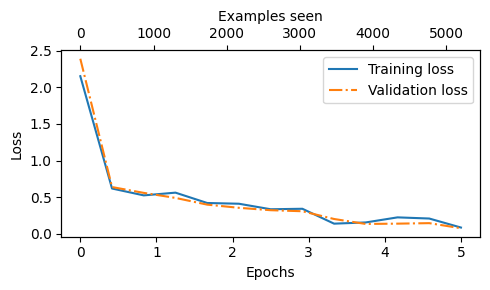

In [38]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- Above, based on the downward slope, we see that the model learns well
- Furthermore, the fact that the training and validation loss are very close indicates that the model does not tend to overfit the training data
- Similarly, we can plot the accuracy below

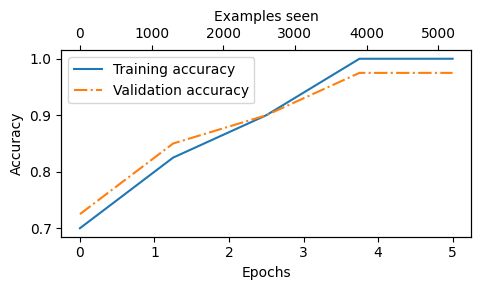

In [39]:
import torch
import matplotlib.pyplot as plt
# 假设前面已经完成了模型的训练过程，并且得到了训练过程中的损失值列表 train_losses，以及处理过的样本数量 examples_seen，同时也设置好了训练的轮次数 num_epochs。
# 使用torch.linspace函数创建一个一维张量，用于表示训练过程中经历的训练轮次的线性间隔值。
# 起始值为0，表示从训练的第0轮开始；结束值为num_epochs，表示到设置的训练轮次数结束；元素数量为len(train_losses)，即与训练损失值列表的长度相同，这样每个损失值都能对应到一个具体的训练轮次。
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# 使用torch.linspace函数创建一个一维张量，用于表示训练过程中已经处理过的训练数据样本数量的线性间隔值。
# 起始值为0，表示从处理0个样本开始；结束值为examples_seen，表示到已经处理过的总样本数量结束；元素数量为len(train_losses)，同样与训练损失值列表的长度相同，以便每个损失值也能对应到一个处理过的样本数量。
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
# 调用之前定义的plot_values函数，传入创建好的表示训练轮次的张量、表示处理过的样本数量的张量、训练损失值列表以及验证损失值列表，
# 该函数会根据传入的这些参数绘制出训练损失值和验证损失值随训练轮次以及处理的样本数量变化的图形，并进行相关的图形设置、保存和展示操作。
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- Based on the accuracy plot above, we can see that the model achieves a relatively high training and validation accuracy after epochs 4 and 5
- However, we have to keep in mind that we specified `eval_iter=5` in the training function earlier, which means that we only estimated the training and validation set performances
- We can compute the training, validation, and test set performances over the complete dataset as follows below

In [40]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


- We can see that the training and validation set performances are practically identical
- However, based on the slightly lower test set performance, we can see that the model overfits the training data to a very small degree, as well as the validation data that has been used for tweaking some of the hyperparameters, such as the learning rate
- This is normal, however, and this gap could potentially be further reduced by increasing the model's dropout rate (`drop_rate`) or the `weight_decay` in the optimizer setting

## 6.8 Using the LLM as a spam classifier

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-4.webp" width=500px>

- Finally, let's use the finetuned GPT model in action
- The `classify_review` function below implements the data preprocessing steps similar to the `SpamDataset` we implemented earlier
- Then, the function returns the predicted integer class label from the model and returns the corresponding class name

In [41]:
# 假设在此之前已经完成了模型的训练过程，并且已经正确定义和初始化了以下对象：
# - train_loader：用于加载训练数据集的PyTorch数据加载器对象，它能够按批次提供训练数据给模型进行处理。
# - val_loader：用于加载验证数据集的PyTorch数据加载器对象，用于在训练过程中对模型在未见过的验证数据上的性能进行评估。
# - test_loader：用于加载测试数据集的PyTorch数据加载器对象，用于在模型训练完成后对模型在全新的测试数据上的性能进行评估。
# - model：已经训练好的模型对象，该模型能够对输入数据进行预测并输出相应的结果。
# - device：表示模型和数据将在其上进行操作的设备，如 'cuda'（GPU）或 'cpu'，确保模型和数据都已被移动到该设备上以便进行高效的计算。
# 使用calc_accuracy_loader函数来计算模型在训练数据集上的准确率。
# 该函数会遍历训练数据加载器提供的批次数据，对每个批次中的输入数据使用模型进行预测，然后将预测结果与真实标签进行比较，
# 最终计算出模型在整个训练数据集上预测正确的样本数量占总样本数量的比例，即准确率。
train_accuracy = calc_accuracy_loader(train_loader, model, device)
# 使用calc_accuracy_loader函数来计算模型在验证数据集上的准确率。
# 同样会遍历验证数据加载器提供的批次数据，进行预测并与真实标签比较，得出模型在验证数据集上预测正确的样本数量占总样本数量的比例。
val_accuracy = calc_accuracy_loader(val_loader, model, device)
# 使用calc_accuracy_loader函数来计算模型在测试数据集上的准确率。
# 按照类似的方式，通过遍历测试数据加载器提供的批次数据，得到模型在测试数据集上预测正确的样本数量占总样本数量的比例。
test_accuracy = calc_accuracy_loader(test_loader, model, device)
# 打印出模型在训练数据集上的准确率，将准确率乘以100并格式化为保留两位小数的百分数形式进行输出，以便更直观地查看模型在训练数据上的性能表现。
print(f"Training accuracy: {train_accuracy*100:.2f}%")
# 打印出模型在验证数据集上的准确率，同样将准确率乘以100并格式化为保留两位小数的百分数形式进行输出，展示模型在验证数据上的性能表现。
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

# 打印出模型在测试数据集上的准确率，也是将准确率乘以100并格式化为保留两位小数的百分数形式进行输出，呈现模型在测试数据上的性能表现。
print(f"Test accuracy: {test_accuracy*100:.2f}%")

- Let's try it out on a few examples below

In [42]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [43]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


- Finally, let's save the model in case we want to reuse the model later without having to train it again

In [44]:
torch.save(model.state_dict(), "review_classifier.pth")

- Then, in a new session, we could load the model as follows

In [45]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Summary and takeaways

- See the [./gpt_class_finetune.py](./gpt_class_finetune.py) script, a self-contained script for classification finetuning
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)
- In addition, interested readers can find an introduction to parameter-efficient training with low-rank adaptation (LoRA) in [appendix E](../../appendix-E)